## Random Forest

We train a random forest classifier on the data set tumour_samples.csv employing cross-entropy as our information criterion for the splits in the decision trees. We use 5-fold cross-validation subsets to explore and optimise over suitable ranges the following hyper-parameters:

1. number of decision trees

2. depth of trees.

We use accuracy as the measure of performance for this hyper-parameter optimisation.

We compare the performance of your optimal random forest classifier on the data set tumour_samples.csv to the performance on the test data tumour_test.csv using different measures computed from the confusion matrix, in particular commenting on accuracy, recall and F1-score.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

Since we work with a dataset that doesn't have uniform weights, we create a function that computes the sample weights as follows
\begin{equation}
\frac{n}{c \cdot b}
\end{equation}
where $n$ is the number of samples, $c$ is the number of classes and $b$ counts how many times the label of the current point appears in $y$.

In [18]:
def calculate_sample_weights(y):
    """
    Input:
    y: training responses
    Output:
    Returns the sample weights for the each entry in y.
    """
    
    labels, counts = np.unique(y, return_counts=True)
    class_weights = {}
    sample_weights = []
    
    # Compute the weights for each class
    for i in range(len(labels)):
        class_weights[labels[i]] = 1 / counts[i] + len(y) / len(labels)
    
    # Assign a weight to each sample according to its label class
    for i in range(len(y)):
        sample_weights.append(class_weights[y[i]])

    return sample_weights

Now we write a function that computes the cross entropy given as 
\begin{equation}
\sum_{i=1}^Q -p \log(p)
\end{equation}
where $p = \mathbb P (y = c_i)$ is the weight of a sample divided by the total weight.

In [19]:
def cross_entropy(y, sample_weights):
    """ 
    Input:
    y: vector of training labels, of shape (N,).
    sample_weights: weights for each samples, of shape (N,).
    Output:
    The cross-entropy for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    crossentropy = 0
    
    for label, weight in label_weights.items():
        prob = weight / total_weight
        crossentropy -= prob * np.log(prob)

    return crossentropy

Next, we define a function to split the data samples based on a feature (column) index and a value.

In [20]:
def split_samples(X, y, sample_weights, column, value, categorical):
  """
  Return the split of data whose column-th feature:
    1. equals value, in case `column` is categorical, or
    2. less than value, in case `column` is not categorical (i.e. numerical)

  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
  """ 

  if categorical:
    left_mask =(X[:, column] == value)
  else:
    left_mask = (X[:, column] < value)
  
  X_left, X_right = X[left_mask, :], X[~left_mask, :]
  y_left, y_right = y[left_mask], y[~left_mask]
  w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

  return (X_left, X_right), (y_left, y_right), (w_left, w_right)

Now we write a function that calculates the crossentropy based on the column we found with the split_value function that minimizes the crossentropy.

In [21]:
def cross_entropy_split_value(X, y, sample_weights, column, categorical):
  """
  Calculate the cross-entropy based on `column` with the split that minimizes the cross-entropy.
  Input:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Output:
      The resulted cross-entropy and the corresponding value used in splitting.
  """
  
  unique_vals = np.unique(X[:, column])

  assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

  crossentropy_val, threshold = np.inf, None
  
  # split the values of i-th feature and calculate the cost 
  for value in unique_vals:
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

    # if one of the two sides is empty, skip this split.
    if len(y_l) == 0 or len(y_r) == 0:
      continue
    
    p_left = sum(w_l)/(sum(w_l) + sum(w_r))
    p_right = 1 - p_left
    new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r)
    if new_cost < crossentropy_val:
      crossentropy_val, threshold = new_cost, value
    
  return crossentropy_val, threshold

In [22]:
def cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict):
  """
  Choose the best feature to split according to criterion.
  Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
  Returns:
      The minimized cross-entropy, the best feature index and value used in splitting.
  """

  columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
  columns_dict = {c: columns_dict[c] for c in columns}
  min_cross_entropy_index, split_column, split_val = np.inf, 0, 0

  for column, categorical in columns_dict.items():

    # skip column if samples are not seperable by that column.
    if len(np.unique(X[:, column])) < 2:
      continue

    # search for the best splitting value for the given column.
    cross_entropy_index, val = cross_entropy_split_value(X, y, sample_weights, column, categorical)    
    
    if cross_entropy_index < min_cross_entropy_index:
        min_cross_entropy_index, split_column, split_val = cross_entropy_index, column, val

  return min_cross_entropy_index, split_column, split_val

Now, we need a function that returns the label which appears the most in our label variable `y`.

In [23]:
def majority_vote(y, sample_weights):
  """
  Input:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Output:
      Return the label which appears the most in y.
  """

  majority_label = {yi: 0 for yi in set(y)}

  for y_i, w_i in zip(y, sample_weights):
    majority_label[y_i] += w_i

  return max(majority_label, key=majority_label.get)

In [24]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth, max_depth, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
  Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
  """
  # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
  if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return {'majority_label': majority_vote(y, sample_weights)}
  
  else:
    CE, split_index, split_val = cross_entropy_split_rf(n_features,
                                                        X,
                                                        y,
                                                        sample_weights,
                                                        columns_dict)
    
    # If CE is infinity, it means that samples are not seperable by the sampled features.
    if CE == np.inf:
      return {'majority_label': majority_vote(y, sample_weights)}
    
    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X,
                                                       y,
                                                       sample_weights,
                                                       split_index,
                                                       split_val,
                                                       categorical)
    return {'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'categorical': categorical,
            'majority_label': None,
            'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)}

In [25]:
def train_rf(B, n_features, X, y, columns_dict, max_depth, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      B: number of decision trees.
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

  feature_names = X.columns.tolist()
  X = X.to_numpy()
  y = y.to_numpy()
  N = X.shape[0]
  training_indices = np.arange(N)
  trees = []

  for _ in range(B):
    sample = np.random.choice(training_indices, N, replace=True)
    X_sample = X[sample, :]
    y_sample = y[sample]
    w_sample = sample_weights[sample]
    tree = build_tree_rf(n_features,
                         X_sample,
                         y_sample,
                         w_sample,
                         columns_dict,
                         feature_names,
                         depth=1,
                         max_depth=max_depth)
    trees.append(tree)

  return trees

Now, we want to use this fitted decision tree to make predictions for our test set `X_test`. To do so, we first define a function `classify` that takes each single data point `x` as an argument. We will write a wrapper function `predict` that calls this `classify` function.

In [26]:
def classify(tree, x):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: ((pd.Dataframe) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  if tree['majority_label'] is not None: 
    return tree['majority_label']

  elif tree['categorical']:
    if x[tree['feature_index']] == tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)

  else:
    if x[tree['feature_index']] < tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)

Let's write the prediction function which aggregates the decision from all decision trees and returns the class with highest probability.

In [29]:
def predict_rf(rf, X):
  """
  Predict classification results for X.
  Args:
      rf: A trained random forest through train_rf function.
      X: (pd.Dataframe) testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """

  def aggregate(decisions):
    count = defaultdict(int)
    for decision in decisions:
      count[decision] += 1
    return max(count, key=count.get)

  if len(X.shape) == 1:
      return aggregate([classify(tree, X) for tree in rf])
  else:
      return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X.to_numpy()])

We also need a function that computes the score.

In [30]:
def rf_score(rf, X_test, y_test):
  """
  Input:
  rf: trained random forest
  X_test: testing features
  y_test: testing labels
  Output:
  Returns the accuracy. 
  """

  y_pred = predict_rf(rf, X_test)
  return np.mean(y_pred==y_test)

Next we write a function that performs a 5-fold cross-validation tuning two parameters: B - the number of trees and max_depth - the maximum allowed depth of a tree.

In [31]:
def cross_validation_score_fr(data, folds, B, max_depth):
    """
    Input:
    data: the whole data
    folds: the indices of the 5 folds
    B: number of decision trees
    max_depth: the maximum depth for the tree
    Output:
    Mean score from validation sets over the 5 folds.
    """

    scores = []
    
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(data.shape[0])) - set(val_indexes))
    
        X_train_i = data.loc[train_indexes, data.columns[: -1]]
        y_train_i = data.loc[train_indexes, data.columns[-1]]

        columns_dict = {index: False for index in range(X_train_i.shape[1])}
        # Take a third of the features as a general rule
        n_features = X_train_i.shape[1] // 3 
        sample_weights = calculate_sample_weights(y_train_i.to_numpy())

        X_val_i = data.loc[val_indexes, data.columns[: -1]]
        y_val_i = data.loc[val_indexes, data.columns[-1]]
        rf = train_rf(B,
                      n_features,
                      X_train_i,
                      y_train_i,
                      columns_dict,
                      max_depth,
                      sample_weights)

        score_i = rf_score(rf, X_val_i, y_val_i)
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

Now we need a function that finds the optimal values for B and max_depth. We will store the score values for each B and max_depth in a matrix with shape (len(B_range), len(max_depth_range)).

In [32]:
def choose_best_parameters(data, folds, B_range, max_depth_range):
    """
    Input:
    data: the whole data
    folds: the indices of the 5 folds
    B_range: the range for the number of decision trees
    max_depth_range: the range for the maximum depth for the tree
    Output:
    Returns the optimal values for B and max_depth and the optimal score.
    """

    # Initialize a matrix that will contain all scores
    scores = np.zeros((len(B_range), len(max_depth_range)))

    # Loop over B_range and max_depth_range
    for i, B in enumerate(B_range):
        for j, max_depth in enumerate(max_depth_range):
            # Store the scores
            scores[i][j] = cross_validation_score_fr(data, folds, B, max_depth)

    # Find the optimal score
    best_parameters_index = np.argmax(scores)

    # Find the indices of the optimal B and optimal max_depth
    B_optimal_index = best_parameters_index//len(max_depth_range)
    max_depth_optimal_index = best_parameters_index%len(max_depth_range)

    # Return the optimal values for B and max_depth and the optimal score
    return B_range[B_optimal_index], max_depth_range[max_depth_optimal_index], scores[B_optimal_index][max_depth_optimal_index]

In [33]:
def cross_validation_split(N, num_folds):
    """
    Input:
    N: length of dataset
    num_folds: number of folds xD
    Output:
    Splits the data into folds.
    """
    
    fold_size = N // num_folds
    index_perm = np.random.permutation(np.arange(N))
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

In [34]:
# Import whole samples data
tumour_samples = pd.read_csv("tumour_samples.csv")
tumour_samples = tumour_samples.drop(columns=['Unnamed: 0'])
diag_map = {'M': 1.0, 'B': 0.0}
tumour_samples['DIAGNOSIS'] = tumour_samples['DIAGNOSIS'].map(diag_map)

# Create folds
folds = cross_validation_split(tumour_samples.shape[0], 5)

# Compute the optimal values for B and max_depth and the optimal score
optimal_B, optimal_max_depth, optimal_score = choose_best_parameters(tumour_samples, 
                                                                     folds,
                                                                     B_range=np.arange(3,6),
                                                                     max_depth_range=np.arange(3, 6))
print("Optimal number of trees:", optimal_B)
print("Optimal max_depth of a tree:", optimal_max_depth)
print("Score of the optimal number of trees and max_depth: ", optimal_score)

Optimal number of trees: 4
Optimal max_depth of a tree: 5
Score of the optimal number of trees and max_depth:  0.9801169590643275


We now fix the hyper-parameters to be the optimal values found above and calculate the accuracy on the entire training set as well as the accuracy on the unseed testing dataset. We need to train a random forest in a similar way to our cross_validation_score_fr function but with the whole training dataset.

In [35]:
# Training set
X_samples_rf = tumour_samples.loc[:, tumour_samples.columns[:-1]]
y_samples_rf = tumour_samples.loc[:, tumour_samples.columns[-1]]

# Define the colums dictionary
columns_dict = {index: False for index in range(X_samples_rf.shape[1])}

# Take the number of features to be 1/3 of the total features
n_features = X_samples_rf.shape[1] // 3

# Calculate the sample weights for the training lables
sample_weights = calculate_sample_weights(y_samples_rf.to_numpy())

# Build and train the random forest with the optimal parameters
rf = train_rf(optimal_B,
              n_features,
              X_samples_rf,
              y_samples_rf,
              columns_dict,
              optimal_max_depth,
              sample_weights)
# Compute the accuracy on the training set
rf_samples_score = rf_score(rf, X_samples_rf, y_samples_rf)

print("The accuracy on the training set is:", rf_samples_score)

The accuracy on the training set is: 0.9805144193296961


In [36]:
# Import testing data
tumour_test = pd.read_csv("tumour_test.csv")
tumour_test = tumour_test.drop(columns=['Unnamed: 0'])
tumour_test['DIAGNOSIS'] = tumour_test['DIAGNOSIS'].map(diag_map)
X_test_rf = tumour_test.loc[:, tumour_test.columns[:-1]]
y_test_rf = tumour_test.loc[:, tumour_test.columns[-1]]

# Compute the accuracy on the testing set
rf_test_score = rf_score(rf, X_test_rf, y_test_rf)

print("The accuracy on the testing set is:", rf_test_score)

The accuracy on the testing set is: 0.96


While the accuracy on the testing set is slightly lower than the score on the training set, it is still very high which suggests that the model did not overfit very much and generalized well.

Next we create several functions to produce the following measures: The Confusion matrix, the True positive rate (recall), the true negative rate, the precision and the F1-score, given by
\begin{align*}
&TPR = \frac{TP}{TP+FN} = recall\\
&TNR = \frac{TN}{TN + FP}\\
&precision = \frac{TP}{TP+FP}\\
&Fscore = 2 \frac{precision \cdot recall}{precision + recall}
\end{align*}

In [37]:
def confusion_matrix(actual, predicted):
    """
    Input:
    actual: the true labels
    predicted: the predicted labels
    Output:
    The confusion matrix for this data.
    """
    # extract the different classes
    classes = np.unique(actual)

    # initialize the confusion matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    # loop across the different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):

           # count the number of instances in each combination of actual / predicted classes
           confusion_matrix[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return confusion_matrix

In [38]:
def recall(actual, predicted):
    """
    Input:
    actual: the true labels
    predicted: the predicted labels
    Output:
    The recall measure.
    """

    confusion_matr = confusion_matrix(actual, predicted)
    TP = confusion_matr[1,1]
    FN = confusion_matr[1,0]
    return TP / (TP + FN)

In [39]:
def true_negative_rate(actual, predicted):
    """
    Input:
    actual: the true labels
    predicted: the predicted labels
    Output:
    The true negative rate.
    """
    
    confusion_matr = confusion_matrix(actual, predicted)
    TN = confusion_matr[0,0]
    FP = confusion_matr[1,0]
    return TN / (TN + FP)

In [40]:
def precision(actual, predicted):
    """
    Input:
    actual: the true labels
    predicted: the predicted labels
    Output:
    The precision.
    """

    confusion_matr = confusion_matrix(actual, predicted)
    TP = confusion_matr[1,1]
    FP = confusion_matr[0,1]
    return TP / (TP + FP)

In [41]:
def f_score(actual, predicted):
    """
    Input:
    actual: the true labels
    predicted: the predicted labels
    Output:
    The F score.
    """
    
    p = precision(actual, predicted)
    r = recall(actual, predicted)
    return 2 * (p * r) / (p + r)

Now that we have our functions, we use our predict_rf function to create a prediction on both the sample and test datasets. Then we plot the confusion matrix for both and the other measures as well.

In [42]:
# Prediction on sample data
y_samples_rf_prediction = predict_rf(rf, X_samples_rf)
# Prediction on test data
y_test_rf_prediction = predict_rf(rf, X_test_rf)

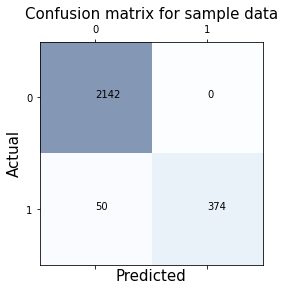

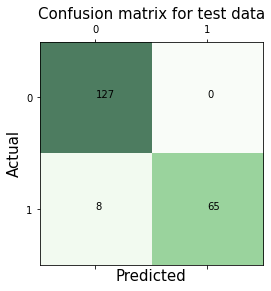

In [43]:
# Compute the two confusion matrices
confusion_matrix_samples = confusion_matrix(y_samples_rf, y_samples_rf_prediction)
confusion_matrix_test = confusion_matrix(y_test_rf, y_test_rf_prediction)

# Plot confusion matrix for the sample data
plt.matshow(confusion_matrix_samples, cmap=plt.cm.Blues, alpha = 0.5)
for i in range(confusion_matrix_samples.shape[0]):
    for j in range(confusion_matrix_samples.shape[1]):
        plt.text(x=j, y=i, s=int(confusion_matrix_samples[i, j]))
 
plt.xlabel("Predicted", size=15)
plt.ylabel("Actual", size=15)
plt.title("Confusion matrix for sample data", size=15)
plt.show()

# Plot confusion matrix for the test data
plt.matshow(confusion_matrix_test, cmap=plt.cm.Greens, alpha = 0.7)
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        plt.text(x=j, y=i, s=int(confusion_matrix_test[i, j]))
 
plt.xlabel("Predicted", size=15)
plt.ylabel("Actual", size=15)
plt.title("Confusion matrix for test data", size=15)
plt.show()

Next we compute the other four measures for the two datasets.

In [44]:
# For the samples data
recall_samples = recall(y_samples_rf, y_samples_rf_prediction)
TNR_samples = true_negative_rate(y_samples_rf, y_samples_rf_prediction)
precision_samples = precision(y_samples_rf, y_samples_rf_prediction)
f_score_samples = f_score(y_samples_rf, y_samples_rf_prediction)

# For the test data
recall_test = recall(y_test_rf, y_test_rf_prediction)
TNR_test = true_negative_rate(y_test_rf, y_test_rf_prediction)
precision_test = precision(y_test_rf, y_test_rf_prediction)
f_score_test = f_score(y_test_rf, y_test_rf_prediction)

# Create a dictionary with all the measures
data = {"Dataset": ["Samples", "Test"],
        "Recall": [recall_samples, recall_test],
        "TNR": [TNR_samples, TNR_test],
        "Precision": [precision_samples, precision_test],
        "F score": [f_score_samples, f_score_test]}

# Create table
pd.DataFrame(data)

,Dataset,Recall,TNR,Precision,F score
0,Samples,0.882075,0.977190,1.0,0.937343
1,Test,0.890411,0.940741,1.0,0.942029


While the true negative rate is higher for the samples dataset, the recall, precision and F-score measures are higher on the unseen testing dataset which indicates that our model didn't overfit and generalized well (note that while it is odd that the scores are hihger on the test dataset, this may be simply )